In [1]:
import os
import ssl
import time
import numpy
import random
import pandas
from matplotlib import pyplot

In [2]:
import torch
from torch import nn, optim
from Dataset import ImageDataset
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [3]:
def set_seed(seed):
    """Sets the seed for reproducibility."""
    random.seed(seed)
    numpy.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
def load_data(path):
    """Loads the data from the given path."""
    folders = [name for name in os.listdir(path) if not name.startswith('.')]
    
    numbers = 0
    for n in range(len(folders)):
        patient_id = folders[n]
        for c in [0, 1]:
            patient_path = path + patient_id 
            class_path = patient_path + "/" + str(c) + "/"
            files = os.listdir(class_path)
            numbers += len(files)
            
    data = pandas.DataFrame(index=numpy.arange(0, numbers), columns=['patient_id', 'path', 'target'])
    
    index = 0
    for n in range(len(folders)):
        patient_id = folders[n]
        patient_path = path + patient_id 
        for c in [0, 1]:
            class_path = patient_path + '/' + str(c) + '/'
            files = os.listdir(class_path)
            for m in range(len(files)):
                image_path = files[m]
                data.loc[index, 'target'] = int(c)
                data.loc[index, 'patient_id'] = patient_id
                data.loc[index, 'path'] = class_path + image_path
                index += 1
    return data

In [5]:
def mean_and_variance(loader):
    mean = 0.0
    variance = 0.0
    number_images = 0

    for images, labels in loader:
        images = images.view(images.size(0), images.size(1), -1)
        number_images += images.size(0)
        
        mean += images.mean(2).sum(0) 
        variance += images.var(2).sum(0)

    mean /= number_images
    variance /= number_images

    return mean, variance

In [6]:
def dataset(data, batch_size, worker_size):
    """Returns the training and testing datasets."""
    train_data, evaluation_data = train_test_split(data, test_size=0.2, random_state=0)
    validation_data, test_data = train_test_split(evaluation_data, test_size=0.5, random_state=0)
    
    initial_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((50, 50), antialias=True)])
    
    initial_dataset = ImageDataset(dataframe=train_data, transform=initial_transform)
    initial_loader = DataLoader(dataset=initial_dataset, batch_size=batch_size, shuffle=True, num_workers=worker_size)
    
    mean, variance = mean_and_variance(initial_loader)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((50, 50), antialias=True), transforms.Normalize(mean, variance.sqrt())])
    
    test_dataset = ImageDataset(dataframe=test_data, transform=transform)
    train_dataset = ImageDataset(dataframe=train_data, transform=transform)
    validation_dataset = ImageDataset(dataframe=validation_data, transform=transform)

    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=worker_size)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=worker_size)
    validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True, num_workers=worker_size)
    
    return train_loader, validation_loader, test_loader

In [7]:
class CNN(nn.Module):
    """Convolutional Neural Network."""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1: 3 x 50 x 50 -> 8 x 48 x 48
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=1), 
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            # Conv Layer block 2: 8 x 48 x 48 -> 8 x 46 x 46
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=1), 
            nn.BatchNorm2d(8), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            # Conv Layer block 2: 8 x 46 x 46 -> 8 x 44 x 44
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=1), 
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            # Conv Layer block 3: 8 x 44 x 44 -> 8 x 42 x 42
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=5, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(8 * 42 * 42, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(128, 16),
            nn.BatchNorm1d(16), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(16, 2)
        )
    
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [8]:
def train_and_validate(model, train_loader, validation_loader, loss_function, optimizer, epochs, device):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    start_time = time.time()
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            optimizer.zero_grad(set_to_none=True)
            loss = loss_function(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            index, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        
        # Validation Phase
        model.eval()
        validation_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                
                loss = loss_function(outputs, labels)
                
                validation_loss += loss.item() * images.size(0)
                index, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        validation_loss /= len(validation_loader.dataset)
        validation_accuracy = correct_val / total_val
        
        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}')
    
    end_time = time.time()
    execution_time = end_time - start_time
    minutes = int(execution_time // 60)
    seconds = int(execution_time % 60)
    print(f"\nExecution time: {minutes:02}:{seconds:02}")
    
    return train_losses, train_accuracies, validation_losses, validation_accuracies

In [9]:
def plot_metrics(path, train_losses, train_accuracies, validation_losses, validation_accuracies):
    """Plots the metrics."""
    figure, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(12, 6))
    epochs = numpy.arange(1, len(train_losses) + 1)
    
    axes[0].plot(epochs, train_losses, label=r'$\mathrm{Train}$')
    axes[0].plot(epochs, validation_losses, label=r'$\mathrm{Validation}$')
    
    axes[0].legend()
    axes[0].set_xlabel(r'$\mathrm{Epochs}$')
    axes[0].set_ylabel(r'$\mathrm{Losses}$')
    
    axes[0].set_xlim([0, len(train_losses)])
    axes[0].set_ylim([0.25, 0.50])
    
    axes[1].plot(epochs, train_accuracies, label=r'$\mathrm{Train}$')
    axes[1].plot(epochs, validation_accuracies, label=r'$\mathrm{Validation}$')
    
    axes[1].legend()
    axes[1].set_xlabel(r'$\mathrm{Epochs}$')
    axes[1].set_ylabel(r'$\mathrm{Accuracies}$')
    
    axes[1].set_xlim([0, len(train_losses)])
    axes[1].set_ylim([0.75, 1.00])
    
    figure.savefig(os.path.join(path, 'METRICS.pdf'), bbox_inches='tight')

In [10]:
set_seed(0)
%matplotlib inline
ssl_create_default_https_context = ssl._create_unverified_context
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cpu


In [11]:
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'DATA/')
PLOT_PATH = os.path.join(PATH, 'PLOT/')
DATA = load_data(DATA_PATH)

In [12]:
EPOCH_SIZE = 24
BATCH_SIZE = 1024
WORKER_SIZE = 128
WEIGHT_DECAY = 0.0001
LEARNING_RATE = 0.0005
LOSS_FUNCTION = nn.CrossEntropyLoss()

In [13]:
TRAIN_LOADER, VALIDATION_LOADER, TEST_LOADER = dataset(DATA, BATCH_SIZE, WORKER_SIZE)
print(f"Train size: {len(TRAIN_LOADER.dataset)}, Validation size: {len(VALIDATION_LOADER.dataset)}, Test size: {len(TEST_LOADER.dataset)}")

Train size: 222019, Validation size: 27752, Test size: 27753


In [14]:
MODEL = CNN().to(DEVICE)
print(MODEL)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True)
    (15): Dropout(p=0.25, inplace=False)
  )
  (fc_layer): Sequential(
    (0): Linear

In [15]:
OPTIMIZER = optim.Adam(MODEL.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
TRAIN_LOSSES, TRAIN_ACCURACIES, VALIDATION_LOSSES, VALIDATION_ACCURACIES = train_and_validate(MODEL, TRAIN_LOADER, VALIDATION_LOADER, LOSS_FUNCTION, OPTIMIZER, EPOCH_SIZE, DEVICE)

Epoch [1/24], Training Loss: 0.42514313983542135, Training Accuracy: 0.8176507416031962, Validation Loss: 0.33641358575995495, Validation Accuracy: 0.8574877486307293
Epoch [2/24], Training Loss: 0.33918637043827804, Training Accuracy: 0.8579265738517875, Validation Loss: 0.31218070918079344, Validation Accuracy: 0.8691625828769097
Epoch [3/24], Training Loss: 0.3212983873364487, Training Accuracy: 0.865128660159716, Validation Loss: 0.3063571930240918, Validation Accuracy: 0.8699913519746325
Epoch [4/24], Training Loss: 0.315519317779674, Training Accuracy: 0.868218485805269, Validation Loss: 0.3080498151594983, Validation Accuracy: 0.8700994522917267
Epoch [5/24], Training Loss: 0.3111360296715411, Training Accuracy: 0.8696778203667254, Validation Loss: 0.29539904221742014, Validation Accuracy: 0.8737027961948688
Epoch [6/24], Training Loss: 0.30917660015500453, Training Accuracy: 0.8711101302140808, Validation Loss: 0.2972040915736619, Validation Accuracy: 0.8720812914384549
Epoch [

In [16]:
%env PATH=/global/homes/y/yhzhang/opt/texlive/bin/x86_64-linux:$PATH
pyplot.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
pyplot.rcParams['pgf.texsystem'] = 'pdflatex'
pyplot.rcParams['text.usetex'] = True
pyplot.rcParams['font.size'] = 20

env: PATH=/global/homes/y/yhzhang/opt/texlive/bin/x86_64-linux:/pscratch/sd/y/yhzhang/MLConda


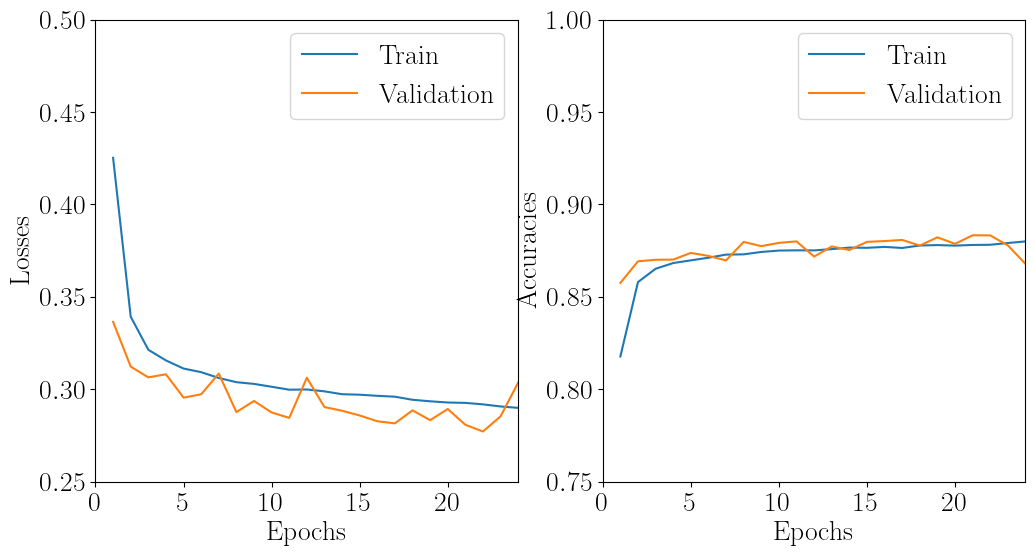

In [17]:
plot_metrics(PLOT_PATH, TRAIN_LOSSES, TRAIN_ACCURACIES, VALIDATION_LOSSES, VALIDATION_ACCURACIES)